#### Set up connection to database

In [1]:
import psycopg2
import pandas as pd

host = 'mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com'
port = "5432"
user = 'lhl_student'
pwd = 'lhl_student'
database = 'mid_term_project'

conn = psycopg2.connect(user = user,
                              password = pwd,
                              host = host,
                              port = port,
                              database = database)
def query(query, conn=conn):
    return pd.read_sql(query, conn)

###### 

###### 

# Task 10

### Do bigger delays lead to bigger fuel comsumption per passenger?

We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

###### 

#### Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)

#### Find out distance covered monthly by different air carriers

In [2]:
#df_carrier_flights = query('select fl_date, op_unique_carrier, arr_delay, distance from flights')

In [3]:
#df_carrier_flights.to_csv('task10_carrier_flights_query.csv', index=False )

In [4]:
df_carrier_flights = pd.read_csv('task10_carrier_flights_query.csv')

In [5]:
df_carrier_flights['fl_date'] = pd.to_datetime(df_carrier_flights['fl_date'], format='%Y-%m-%d')

In [6]:
df_carrier_flights['fl_month'] = df_carrier_flights['fl_date'].dt.month
df_carrier_flights['fl_year'] = df_carrier_flights['fl_date'].dt.year

In [7]:
df_carrier_flights_group = df_carrier_flights[['op_unique_carrier','fl_year','fl_month','arr_delay','distance']].\
groupby(['op_unique_carrier','fl_year','fl_month']).agg(arr_delay_mean = ('arr_delay','mean'), distance_total = ('distance','sum')).\
                                              sort_values(['op_unique_carrier','fl_year','fl_month']).reset_index()

In [8]:
df_carrier_flights_group.head()

,op_unique_carrier,fl_year,fl_month,arr_delay_mean,distance_total
0,9E,2018,1,3.261829,8167585.0
1,9E,2018,2,5.073699,8376340.0
2,9E,2018,3,3.425646,9823256.0
3,9E,2018,4,6.901152,9497942.0
4,9E,2018,5,1.900127,9976523.0


###### 

#### Find out number of passengers that were carried by different air carriers

In [9]:
#df_carrier_pax = query('select unique_carrier, year, month, passengers, departures_performed from passengers')

In [10]:
#df_carrier_pax.to_csv('task10_carrier_pax_query.csv', index=False )

In [11]:
df_carrier_pax = pd.read_csv('task10_carrier_pax_query.csv')

In [12]:
df_carrier_pax['pax_per_flight'] = df_carrier_pax['passengers'] / df_carrier_pax['departures_performed']

In [13]:
df_carrier_pax.head()

,unique_carrier,year,month,passengers,departures_performed,pax_per_flight
0,G4,2018,5,942.0,7.0,134.571429
1,G4,2018,5,923.0,7.0,131.857143
2,G4,2018,5,899.0,7.0,128.428571
3,G4,2018,5,925.0,7.0,132.142857
4,G4,2018,5,829.0,7.0,118.428571


In [14]:
df_carrier_pax_group = df_carrier_pax[['unique_carrier', 'year', 'month', 'pax_per_flight']].\
groupby(['unique_carrier', 'year', 'month']).mean().sort_values(['unique_carrier', 'year', 'month']).reset_index()

In [15]:
df_carrier_pax_group.head()

,unique_carrier,year,month,pax_per_flight
0,02Q,2015,2,187.000000
1,02Q,2015,3,265.000000
2,02Q,2015,4,212.000000
3,02Q,2015,5,118.142857
4,02Q,2015,6,77.000000


###### 

#### Find out total fuel comsumption per air carrier

In [16]:
#df_carrier_fuel = query('select unique_carrier, year, month, total_gallons from fuel_comsumption')

In [17]:
#df_carrier_fuel.to_csv('task10_carrier_fuel_query.csv', index=False )

In [18]:
df_carrier_fuel = pd.read_csv('task10_carrier_fuel_query.csv')

In [19]:
df_carrier_fuel.head()

,unique_carrier,year,month,total_gallons
0,NaN,2016,1,3000.0
1,0WQ,2016,1,210112.0
2,23Q,2016,1,0.0
3,27Q,2016,1,0.0
4,5V,2016,1,284362.0


###### 

#### Merge the three tables

In [20]:
df_2018_2019_flights = df_carrier_flights_group[df_carrier_flights_group['fl_year'] >= 2018]
df_2018_2019_pax = df_carrier_pax_group[df_carrier_pax_group['year'] >= 2018]
df_2018_2019_fuel = df_carrier_fuel[df_carrier_fuel['year'] >= 2018]

In [21]:
def createConcatKey(carrier, year, month):
    return str(carrier) + str(year) + str(month)

In [22]:
df_2018_2019_flights['concat_key'] = df_2018_2019_flights.apply(lambda row: createConcatKey(row['op_unique_carrier'], \
                                                                                            row['fl_year'], \
                                                                                            row['fl_month']), axis=1) 

In [23]:
df_2018_2019_pax['concat_key'] = df_2018_2019_pax.apply(lambda row: createConcatKey(row['unique_carrier'], \
                                                                                            row['year'], \
                                                                                            row['month']), axis=1) 

<ipython-input-23-bc88118c541f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019_pax['concat_key'] = df_2018_2019_pax.apply(lambda row: createConcatKey(row['unique_carrier'], \


In [24]:
df_2018_2019_fuel['concat_key'] = df_2018_2019_fuel.apply(lambda row: createConcatKey(row['unique_carrier'], \
                                                                                            row['year'], \
                                                                                            row['month']), axis=1) 

<ipython-input-24-23b147c8c420>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_2019_fuel['concat_key'] = df_2018_2019_fuel.apply(lambda row: createConcatKey(row['unique_carrier'], \


In [25]:
df_2018_2019_flights.head()

,op_unique_carrier,fl_year,fl_month,arr_delay_mean,distance_total,concat_key
0,9E,2018,1,3.261829,8167585.0,9E20181
1,9E,2018,2,5.073699,8376340.0,9E20182
2,9E,2018,3,3.425646,9823256.0,9E20183
3,9E,2018,4,6.901152,9497942.0,9E20184
4,9E,2018,5,1.900127,9976523.0,9E20185


In [26]:
df_2018_2019_pax.head()

,unique_carrier,year,month,pax_per_flight,concat_key
15,02Q,2018,3,12.500000,02Q20183
16,02Q,2018,4,23.800000,02Q20184
17,02Q,2018,6,14.900000,02Q20186
18,02Q,2019,2,138.000000,02Q20192
19,02Q,2019,5,52.666667,02Q20195


In [27]:
df_2018_2019_fuel.head()

,unique_carrier,year,month,total_gallons,concat_key
1977,09Q,2019,1,1235210.0,09Q20191
1978,0WQ,2019,1,0.0,0WQ20191
1979,1BQ,2019,1,60821.0,1BQ20191
1980,27Q,2019,1,0.0,27Q20191
1981,2HQ,2019,1,410186.0,2HQ20191


In [28]:
df_2018_2019_merged = pd.merge(df_2018_2019_flights, df_2018_2019_pax, on='concat_key', how='left')

In [29]:
df_2018_2019_merged = pd.merge(df_2018_2019_merged, df_2018_2019_fuel, on='concat_key', how='left')

In [30]:
df_2018_2019_merged = df_2018_2019_merged.drop(['unique_carrier_x','year_x','month_x','unique_carrier_y',\
                                                'year_y','month_y'], axis=1)

In [31]:
first_col = df_2018_2019_merged.pop('concat_key')
df_2018_2019_merged.insert(0, 'concat_key', first_col)
df_2018_2019_merged.head()

,concat_key,op_unique_carrier,fl_year,fl_month,arr_delay_mean,distance_total,pax_per_flight,total_gallons
0,9E20181,9E,2018,1,3.261829,8167585.0,47.648059,0.0
1,9E20182,9E,2018,2,5.073699,8376340.0,48.753926,0.0
2,9E20183,9E,2018,3,3.425646,9823256.0,52.850828,0.0
3,9E20184,9E,2018,4,6.901152,9497942.0,52.995243,0.0
4,9E20185,9E,2018,5,1.900127,9976523.0,54.623276,0.0


###### 

#### Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [32]:
df_2018_2019_merged['litres_per_pax_per_100km'] = (df_2018_2019_merged['total_gallons'] * 3.785411784) / \
(df_2018_2019_merged['distance_total'] * 1.609344 / 100)/ df_2018_2019_merged['pax_per_flight']

In [33]:
df_2018_2019_merged.head()

,concat_key,op_unique_carrier,fl_year,fl_month,arr_delay_mean,distance_total,pax_per_flight,total_gallons,litres_per_pax_per_100km
0,9E20181,9E,2018,1,3.261829,8167585.0,47.648059,0.0,0.0
1,9E20182,9E,2018,2,5.073699,8376340.0,48.753926,0.0,0.0
2,9E20183,9E,2018,3,3.425646,9823256.0,52.850828,0.0,0.0
3,9E20184,9E,2018,4,6.901152,9497942.0,52.995243,0.0,0.0
4,9E20185,9E,2018,5,1.900127,9976523.0,54.623276,0.0,0.0


In [34]:
df_task10 = df_2018_2019_merged.dropna()

In [35]:
df_task10 = df_task10[df_task10['total_gallons'] > 0]

In [36]:
df_task10.head(20)

,concat_key,op_unique_carrier,fl_year,fl_month,arr_delay_mean,distance_total,pax_per_flight,total_gallons,litres_per_pax_per_100km
29,AA20181,AA,2018,1,0.429125,73930041.0,126.262798,283974071.0,7.155609
30,AA20182,AA,2018,2,2.009694,69007046.0,127.451266,261946387.0,7.005499
31,AA20183,AA,2018,3,-0.213830,79512758.0,135.099365,298906244.0,6.544992
32,AA20184,AA,2018,4,0.515217,75093912.0,134.422841,297784292.0,6.938862
33,AA20185,AA,2018,5,5.950072,79376480.0,136.011181,318954880.0,6.949076
34,AA20186,AA,2018,6,9.798884,81807311.0,139.273604,327277749.0,6.756469
35,AA20187,AA,2018,7,13.011832,84899409.0,142.384418,341082450.0,6.636766
36,AA20188,AA,2018,8,11.225474,83291459.0,136.980473,334937605.0,6.905085
37,AA20189,AA,2018,9,5.843163,75823308.0,128.108857,302313376.0,7.320483
38,AA201810,AA,2018,10,6.403908,78648799.0,134.653057,309826329.0,6.881360


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import numpy as np

In [39]:
np.corrcoef(df_task10[~df_task10['op_unique_carrier'].isin(['YX'])]['arr_delay_mean'], \
            df_task10[~df_task10['op_unique_carrier'].isin(['YX'])]['litres_per_pax_per_100km'])

array([[ 1.        , -0.22183515],
       [-0.22183515,  1.        ]])

In [40]:
import scipy.stats as stats

In [41]:
z_delay = stats.zscore(df_task10[~df_task10['op_unique_carrier'].isin(['YX'])]['arr_delay_mean'])
z_fuel = stats.zscore(df_task10[~df_task10['op_unique_carrier'].isin(['YX'])]['litres_per_pax_per_100km'])

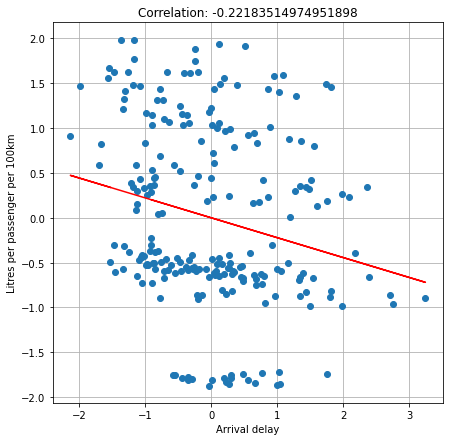

In [45]:
plt.figure(figsize=(7,7))


#create basic scatterplot
plt.plot(z_delay, z_fuel, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(z_delay, z_fuel, 1)

#add linear regression line to scatterplot 
plt.plot(z_delay, m*z_delay+b, color='r')
plt.title('Correlation: ' + str(m))
plt.ylabel('Litres per passenger per 100km')
plt.xlabel('Arrival delay')
plt.grid(True)
plt.show()

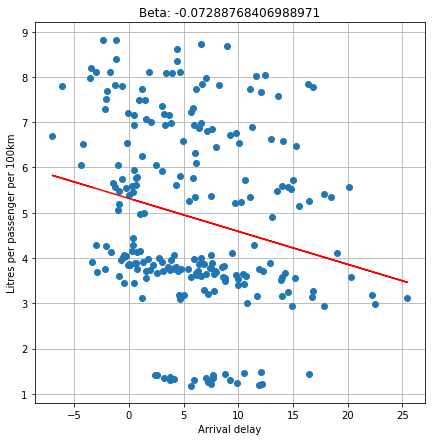

In [46]:
plt.figure(figsize=(7,7))


x = df_task10[~df_task10['op_unique_carrier'].isin(['YX'])]['arr_delay_mean']
y = df_task10[~df_task10['op_unique_carrier'].isin(['YX'])]['litres_per_pax_per_100km']


#create basic scatterplot
plt.plot(x, y, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color='r')
plt.title('Beta: ' + str(m))
plt.ylabel('Litres per passenger per 100km')
plt.xlabel('Arrival delay')
plt.grid(True)
plt.show()

In [47]:
import statsmodels.api as sm

In [48]:
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     litres_per_pax_per_100km   R-squared:                       0.049
Model:                                  OLS   Adj. R-squared:                  0.045
Method:                       Least Squares   F-statistic:                     11.85
Date:                      Thu, 22 Oct 2020   Prob (F-statistic):           0.000684
Time:                              21:05:08   Log-Likelihood:                -479.89
No. Observations:                       231   AIC:                             963.8
Df Residuals:                           229   BIC:                             970.7
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3173      0.178     29.820      0.000       4.966       5.669
arr_delay_mean    -0.0729      0.021     -3.443      0.001      -0.115      -0.031
==============================================================================
Omnibus:                       16.239   Durbin-Watson:                   0.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.603
Skew:                           0.124   Prob(JB):                       0.0368
Kurtosis:                       2.210   Cond. No.                         11.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 

# There is a slight negative relationship between fuel consumption and delay time, but the relationship is not significant. 

# This slight relationship can be explained by noting the when there is a delay, we do find that the plane excelerate but they can only excelerate by so much since they are already traveling close to optimal speed.